# Consolidated Workspace Notebook


In [49]:
# Safety defaults and paths
from pathlib import Path
# Safe defaults so dependent cells don't crash if not executed earlier
notebooks = notebooks if 'notebooks' in globals() else []
loaded = loaded if 'loaded' in globals() else []
code_cells = code_cells if 'code_cells' in globals() else []
md_cells = md_cells if 'md_cells' in globals() else []
unique_imports = unique_imports if 'unique_imports' in globals() else []
merged_import_cell = merged_import_cell if 'merged_import_cell' in globals() else {
    'cell_type': 'code', 'metadata': {}, 'source': ['# merged imports placeholder\n']
}
func_defs = func_defs if 'func_defs' in globals() else []
load_cells = load_cells if 'load_cells' in globals() else []
model_cells = model_cells if 'model_cells' in globals() else []
viz_cells = viz_cells if 'viz_cells' in globals() else []
ordered_cells = ordered_cells if 'ordered_cells' in globals() else []

# Project-relative data paths
proj_root = Path('..').resolve()
mt_dir = proj_root / '05_model_training'
ed_dir = proj_root / '01_datenerfassung'
PART1 = ed_dir / 'data_falcon9_part_1.csv'
PART1_ALT = ed_dir / 'data_falcon9_part_1.1.csv'
PART2 = mt_dir / 'dataset_part_2.csv'
PART3 = mt_dir / 'dataset_part_3.csv'
print('Data paths exist:', {
    'PART1': PART1.exists(),
    'PART1_ALT': PART1_ALT.exists(),
    'PART2': PART2.exists(),
    'PART3': PART3.exists(),
})

Data paths exist: {'PART1': True, 'PART1_ALT': True, 'PART2': True, 'PART3': True}


In [50]:
# Load raw launches dataset (Part 1) if available
import pandas as pd
try:
    if 'df_part1' in globals() and isinstance(df_part1, pd.DataFrame):
        pass  # already loaded
    else:
        if PART1.exists():
            df_part1 = pd.read_csv(PART1)
        elif PART1_ALT.exists():
            df_part1 = pd.read_csv(PART1_ALT)
        else:
            # fallback to local working dir if user runs from 01_datenerfassung
            df_part1 = pd.read_csv('data_falcon9_part_1.csv')
    print('df_part1 shape:', df_part1.shape)
except Exception as e:
    print('Failed to load Part 1 launches dataset:', e)
    df_part1 = pd.DataFrame()

df_part1 shape: (90, 17)


In [40]:
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
from folium.features import DivIcon
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from math import radians, sin, cos, sqrt, atan2
from pathlib import Path
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import csv, sqlite3
import datetime
import folium
import io
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prettytable
import re
import requests
import seaborn as sns
import sys
import unicodedata


In [41]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    


In [42]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

In [ ]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
        

In [51]:
# Clean and subset raw launches (Part 1) safely
# Expecting columns: ['rocket','payloads','launchpad','cores','flight_number','date_utc']
import datetime
if 'df_part1' in globals() and not df_part1.empty:
    required_cols = ['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']
    if all(col in df_part1.columns for col in required_cols):
        df_part1 = df_part1[required_cols].copy()
        # Keep rows with exactly one core and one payload
        df_part1 = df_part1[df_part1['cores'].map(len) == 1]
        df_part1 = df_part1[df_part1['payloads'].map(len) == 1]
        # Extract list values to scalars
        df_part1['cores'] = df_part1['cores'].map(lambda x: x[0])
        df_part1['payloads'] = df_part1['payloads'].map(lambda x: x[0])
        # Convert and filter date
        df_part1['date'] = pd.to_datetime(df_part1['date_utc']).dt.date
        df_part1 = df_part1[df_part1['date'] <= datetime.date(2020, 11, 13)]
        print('df_part1 cleaned:', df_part1.shape)
    else:
        print('df_part1 missing expected columns; found:', sorted(df_part1.columns.tolist())[:12], '...')
else:
    print('df_part1 not loaded or empty; skipping Part 1 cleaning.')

df_part1 missing expected columns; found: ['Block', 'BoosterVersion', 'Date', 'FlightNumber', 'Flights', 'GridFins', 'LandingPad', 'Latitude', 'LaunchSite', 'Legs', 'Longitude', 'Orbit'] ...


In [45]:
#Global variables 
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [ ]:
# Call getPayloadData
getPayloadData(data)

In [ ]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}


In [6]:
# Calculate the mean value of PayloadMass column
pl_mean = data_falcon9.PayloadMass.mean()
# Replace the np.nan values with its mean value
data_falcon9.PayloadMass.replace(np.nan, pl_mean, inplace=True)
print(data_falcon9["PayloadMass"].isna().sum())

NameError: name 'data_falcon9' is not defined

In [7]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

NameError: name 'column_names' is not defined

In [8]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            launch_dict['Flight No.'].append(flight_number)
            print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            launch_dict['Time'].append(time)
            print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            launch_dict['Version Booster'].append(bv)    
            print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            if row[2].a and row[2].a.string:
                launch_site = row[2].a.string.strip()
            else:
                launch_site = row[2].get_text(strip=True)
            launch_dict['Launch site'].append(launch_site)
            print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            if row[3].a and row[3].a.string:
                payload = row[3].a.string.strip()
            else:
                payload = row[3].get_text(strip=True)
            launch_dict['Payload'].append(payload)
            print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            print(payload_mass)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            if row[5].a and row[5].a.string:
                orbit = row[5].a.string.strip()
            else:
                orbit = row[5].get_text(strip=True)
            launch_dict['Orbit'].append(orbit)
            print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a and row[6].a.string:
                customer = row[6].a.string.strip()
            else:
                customer = row[6].get_text(strip=True)
            launch_dict['Customer'].append(customer)
            print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)
            print(booster_landing)
            

NameError: name 'soup' is not defined

In [9]:
df=pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_1.csv")
df.head(10)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857
5,6,2014-01-06,Falcon 9,3325.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1005,-80.577366,28.561857
6,7,2014-04-18,Falcon 9,2296.000000,ISS,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1006,-80.577366,28.561857
7,8,2014-07-14,Falcon 9,1316.000000,LEO,CCAFS SLC 40,True Ocean,1,False,False,True,NaN,1.0,0,B1007,-80.577366,28.561857
8,9,2014-08-05,Falcon 9,4535.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1008,-80.577366,28.561857
9,10,2014-09-07,Falcon 9,4428.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1011,-80.577366,28.561857


In [10]:


import requests
import io

URL = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
response = requests.get(URL)
dataset_part_2_csv = io.BytesIO(response.content)
df = pd.read_csv(dataset_part_2_csv)
df.head(5)

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


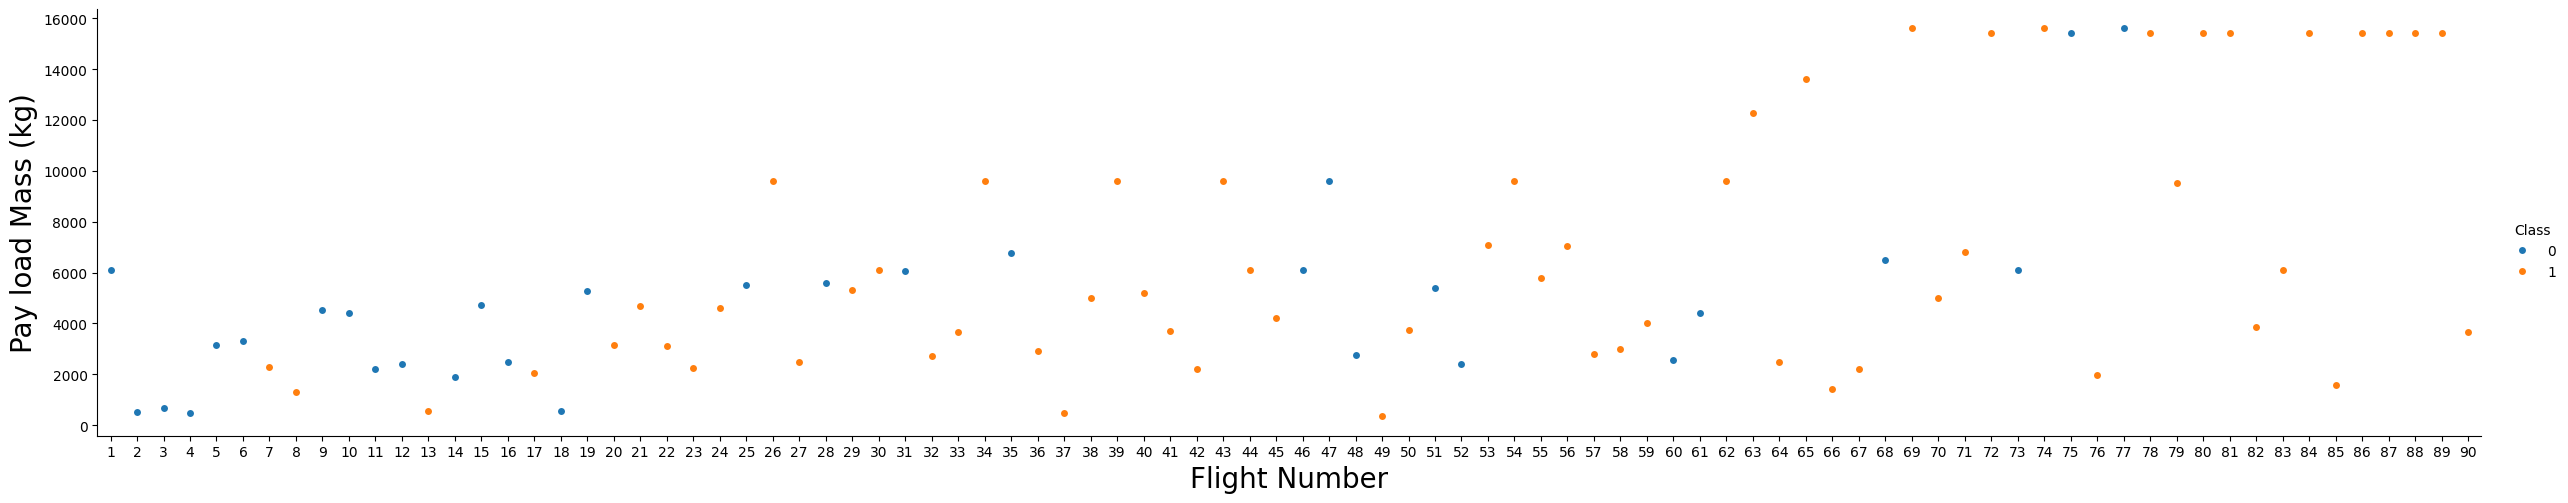

In [11]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

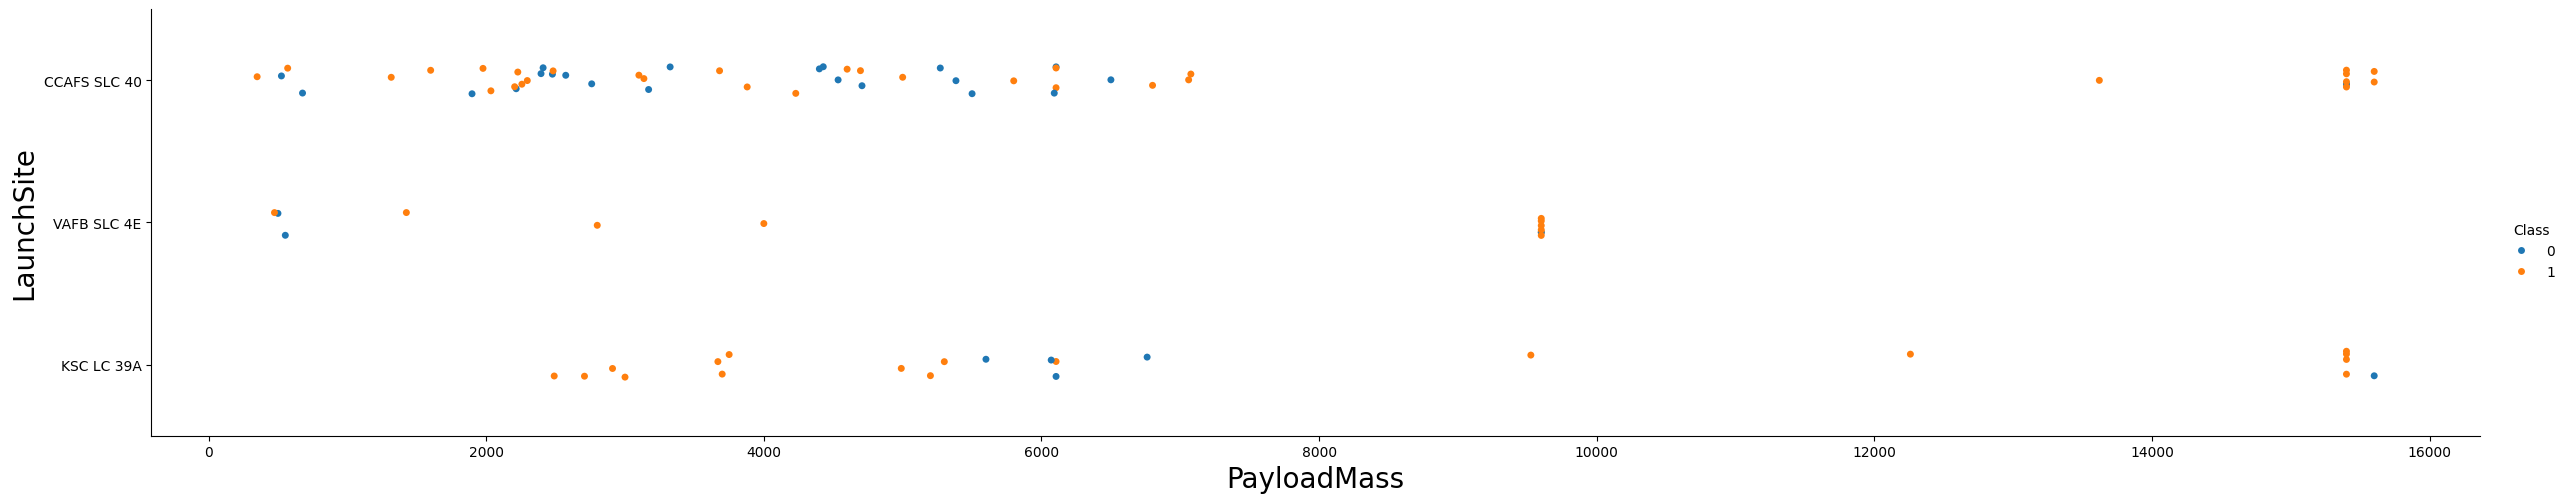

In [12]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite",x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

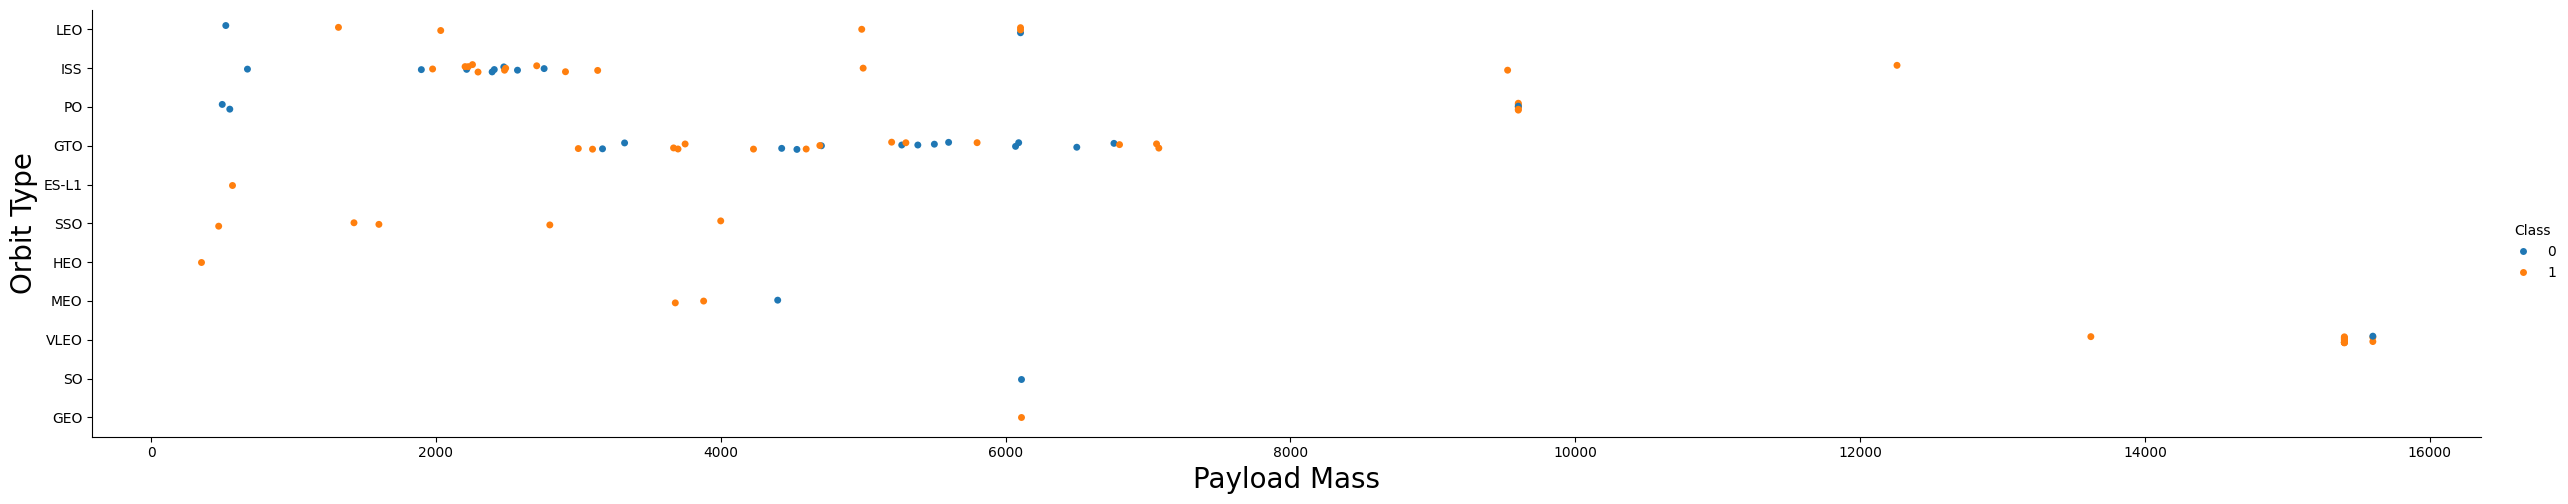

In [13]:
# Plot a scatter point chart with x axis to be Payload Mass and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit",x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("Payload Mass",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()

In [14]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
0,1,6104.959412,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0003
1,2,525.000000,LEO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0005
2,3,677.000000,ISS,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B0007
3,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,NaN,1.0,0,B1003
4,5,3170.000000,GTO,CCAFS SLC 40,1,False,False,False,NaN,1.0,0,B1004


In [15]:
df[df['LaunchSite'].str.startswith('CCA')][['FlightNumber', 'LaunchSite', 'PayloadMass', 'Orbit', 'Class']].head(5)

,FlightNumber,LaunchSite,PayloadMass,Orbit,Class
0,1,CCAFS SLC 40,6104.959412,LEO,0
1,2,CCAFS SLC 40,525.000000,LEO,0
2,3,CCAFS SLC 40,677.000000,ISS,0
4,5,CCAFS SLC 40,3170.000000,GTO,0
5,6,CCAFS SLC 40,3325.000000,GTO,0


In [16]:
%load_ext sql

In [17]:
import pandas as pd
df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

NameError: name 'con' is not defined

In [ ]:
# Download und Einlesen der CSV-Datei (lokal oder per URL)
import pandas as pd

# Versuche zuerst, die Datei lokal zu laden
try:
    spacex_df = pd.read_csv("spacex_launch_geo.csv")
except FileNotFoundError:
    # Falls nicht lokal vorhanden, lade sie direkt von der URL
    url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv"
    spacex_df = pd.read_csv(url)

spacex_df.head()

,Flight Number,Date,Time (UTC),Booster Version,Launch Site,Payload,Payload Mass (kg),Orbit,Customer,Landing Outcome,class,Lat,Long
0,1,2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Failure (parachute),0,28.562302,-80.577356
1,2,2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel o...",0.0,LEO (ISS),NASA (COTS) NRO,Failure (parachute),0,28.562302,-80.577356
2,3,2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2+,525.0,LEO (ISS),NASA (COTS),No attempt,0,28.562302,-80.577356
3,4,2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356
4,5,2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677.0,LEO (ISS),NASA (CRS),No attempt,0,28.562302,-80.577356


In [ ]:
# Load the dataframe (local CSV)
import pandas as pd
try:
    if PART2.exists():
        data = pd.read_csv(PART2)
    else:
        data = pd.read_csv('dataset_part_2.csv')  # fallback if running from original folder
except Exception as e:
    print('Failed to load dataset_part_2.csv:', e)
    data = pd.DataFrame()
print('data shape:', data.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_part_2.csv'

In [ ]:
# Load feature matrix (local CSV)
import pandas as pd
try:
    if PART3.exists():
        X = pd.read_csv(PART3)
    else:
        X = pd.read_csv('dataset_part_3.csv')  # fallback if running from original folder
except Exception as e:
    print('Failed to load dataset_part_3.csv:', e)
    X = pd.DataFrame()
print('X shape:', X.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset_part_3.csv'

In [20]:
# Notebook-JSON Laden
import json
loaded = []
for p in notebooks:
    try:
        with open(p, 'r', encoding='utf-8') as f:
            loaded.append((p, json.load(f)))
    except json.JSONDecodeError:
        print(f'Übersprungen (defekt): {p}')
print(f'Geladene Notebooks: {len(loaded)}')

NameError: name 'notebooks' is not defined

In [21]:
# Code- und Markdown-Zellen Extrahieren
code_cells = []
md_cells = []
for path, nb in loaded:
    for cell in nb.get('cells', []):
        if cell.get('cell_type') == 'code':
            code_cells.append(cell)
        elif cell.get('cell_type') == 'markdown':
            md_cells.append(cell)
print(len(code_cells), 'Codezellen', '|', len(md_cells), 'Markdownzellen')

0 Codezellen | 0 Markdownzellen


In [22]:
# Datenlade- und Preprocessing-Schritte Sammeln
load_cells = []
keywords = ['read_csv', 'load', 'DataLoader', 'pd.read', 'np.load']
for c in code_cells:
    text = ''.join(c.get('source', []))
    if any(k in text for k in keywords):
        load_cells.append(c)
print('Daten-/Preprocessing-Zellen:', len(load_cells))

Daten-/Preprocessing-Zellen: 0


In [23]:
# Zellen Reihenfolge Heuristik Anwenden
ordered_cells = []
# Markdown Intro
ordered_cells.append({'cell_type': 'markdown', 'metadata': {}, 'source': ['# Consolidated Workspace Notebook\n']})
# Imports
ordered_cells.append(merged_import_cell)
# Funktionen
ordered_cells.extend(func_defs)
# Daten Laden
ordered_cells.extend(load_cells)
# Modelle
ordered_cells.extend(model_cells)
# Visualisierung
ordered_cells.extend(viz_cells)
print('Reihenfolge erstellt:', len(ordered_cells), 'Zellen')

NameError: name 'merged_import_cell' is not defined

In [24]:
# landing_class = 0 if bad_outcome
landing_class = []
for o in df.Outcome:
    if o in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)
# landing_class = 1 otherwise

AttributeError: 'DataFrame' object has no attribute 'Outcome'

In [25]:
# Plot a scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

ValueError: Could not interpret value `FlightNumber` for `x`. An entry with this name does not appear in `data`.

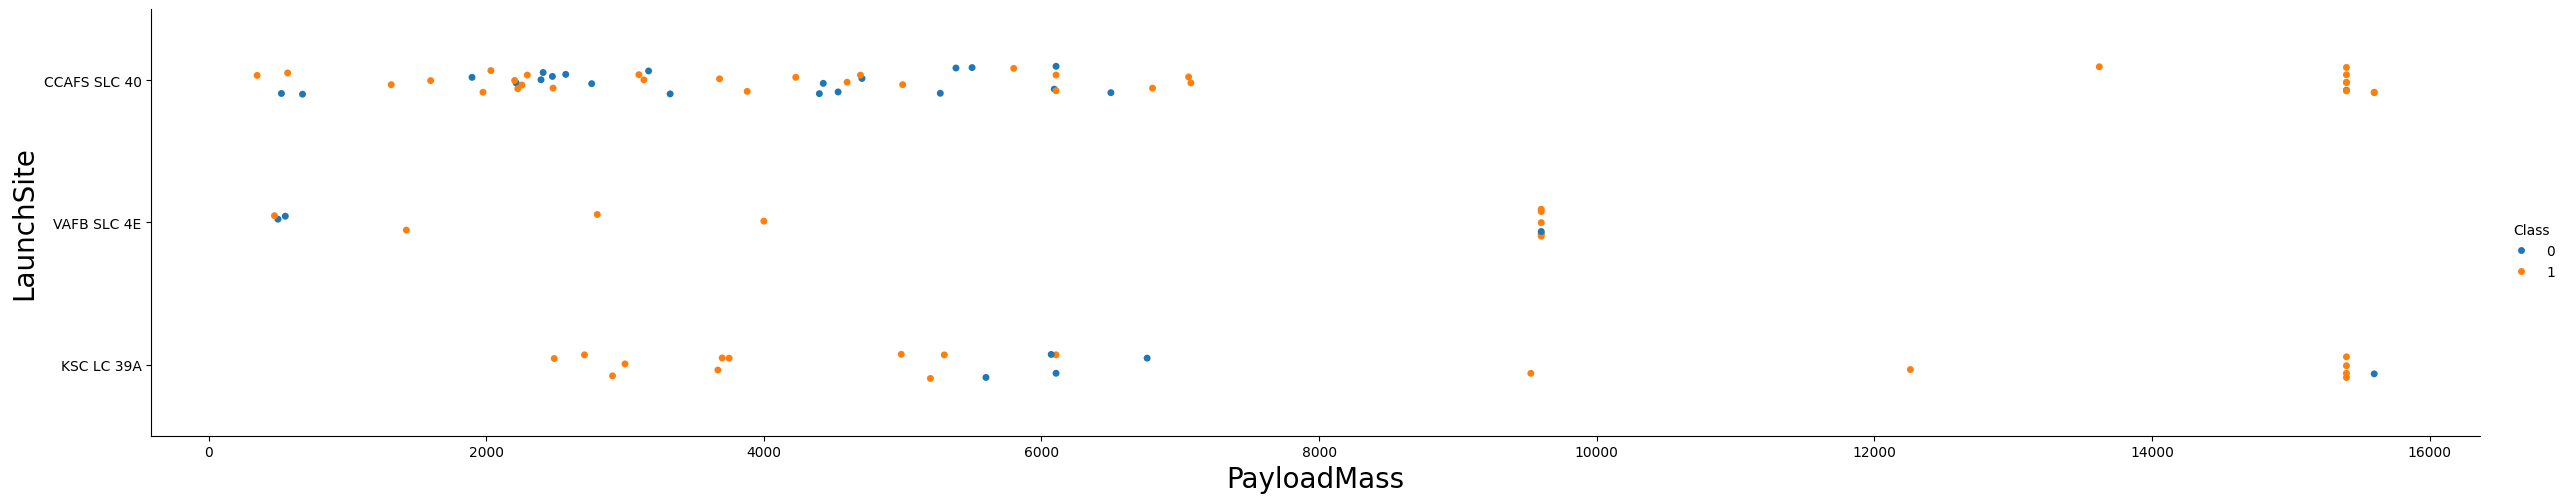

In [ ]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite",x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

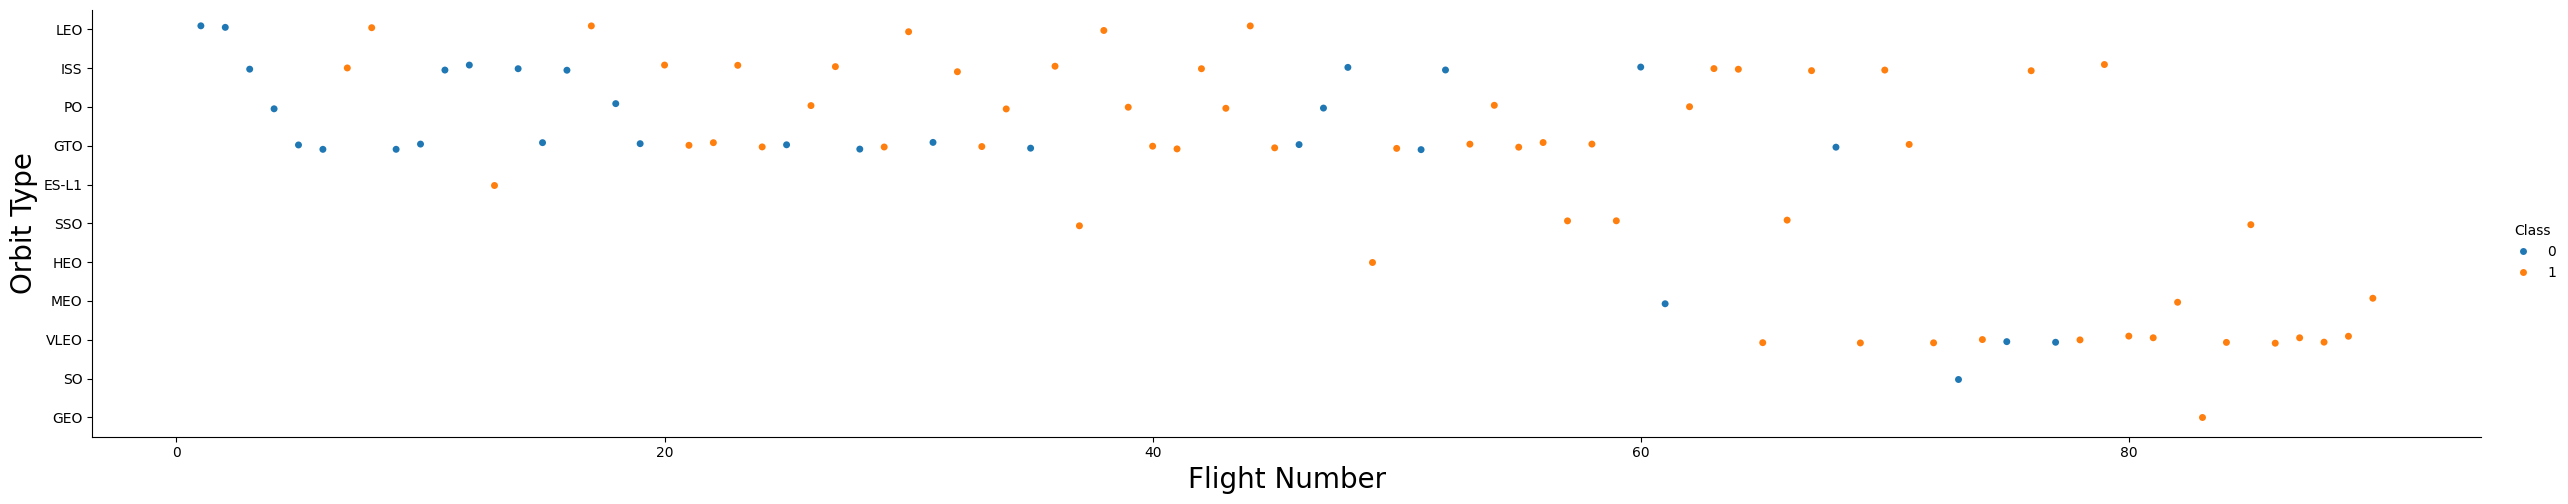

In [ ]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit",x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()


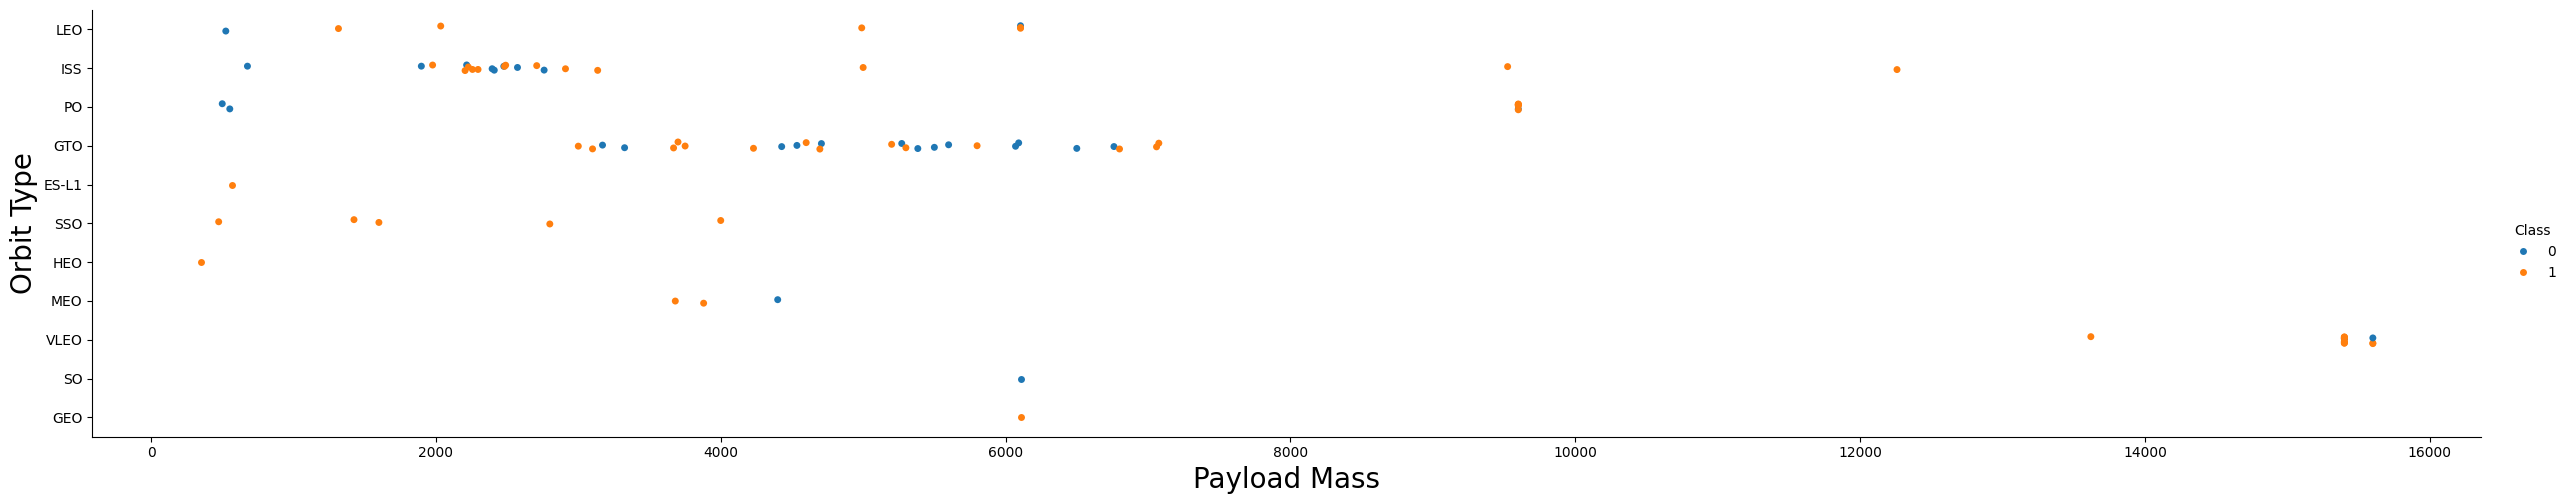

In [ ]:
# Plot a scatter point chart with x axis to be Payload Mass and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit",x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("Payload Mass",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()

In [ ]:
# Logistic Regression minimal GridSearch (guarded)
if 'X' in globals() and not X.empty and 'data' in globals() and not data.empty and 'Class' in data.columns:
    Y = data['Class'].to_numpy()
    try:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
        parameters = {"C":[0.01,0.1,1], 'penalty':['l2'], 'solver':['lbfgs']}
        lr = LogisticRegression(max_iter=500)
        logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=5)  # reduce cv for speed
        logreg_cv.fit(X_train, Y_train)
        print('LogReg best params:', logreg_cv.best_params_, 'score:', f"{logreg_cv.best_score_:.3f}")
    except Exception as e:
        print('LogReg training skipped due to error:', e)
else:
    print('LogReg skipped: data or labels unavailable.')

NameError: name 'X_train' is not defined

In [ ]:
# Confusion matrix for Logistic Regression (guarded)
if 'logreg_cv' in globals() and 'X_test' in globals():
    try:
        yhat = logreg_cv.predict(X_test)
        plot_confusion_matrix(Y_test, yhat)
    except Exception as e:
        print('LogReg confusion matrix skipped:', e)
else:
    print('LogReg confusion matrix skipped: model or test set missing.')

NameError: name 'X_test' is not defined

In [ ]:
# SVM minimal GridSearch (guarded)
if 'X_train' in globals():
    try:
        svm = SVC()
        parameters = {'kernel':('linear','rbf'), 'C':[0.1,1]}
        svm_cv = GridSearchCV(estimator=svm, param_grid=parameters, cv=5)
        svm_cv.fit(X_train, Y_train)
        print('SVM best params:', svm_cv.best_params_, 'score:', f"{svm_cv.best_score_:.3f}")
    except Exception as e:
        print('SVM training skipped due to error:', e)
else:
    print('SVM skipped: train set missing.')

NameError: name 'svm' is not defined

In [ ]:
# Confusion matrix for SVM (guarded)
if 'svm_cv' in globals() and 'X_test' in globals():
    try:
        yhat = svm_cv.predict(X_test)
        plot_confusion_matrix(Y_test, yhat)
    except Exception as e:
        print('SVM confusion matrix skipped:', e)
else:
    print('SVM confusion matrix skipped: model or test set missing.')

NameError: name 'svm_cv' is not defined

In [ ]:
# Decision Tree minimal GridSearch (guarded)
if 'X_train' in globals():
    try:
        tree = DecisionTreeClassifier(random_state=2)
        parameters = {'max_depth':[2,4,6], 'criterion':['gini','entropy']}
        tree_cv = GridSearchCV(estimator=tree, param_grid=parameters, cv=5)
        tree_cv.fit(X_train, Y_train)
        print('Tree best params:', tree_cv.best_params_, 'score:', f"{tree_cv.best_score_:.3f}")
    except Exception as e:
        print('Tree training skipped due to error:', e)
else:
    print('Tree skipped: train set missing.')

NameError: name 'tree' is not defined

In [ ]:
# Confusion matrix for Decision Tree (guarded)
if 'tree_cv' in globals() and 'X_test' in globals():
    try:
        yhat = tree_cv.predict(X_test)
        plot_confusion_matrix(Y_test, yhat)
    except Exception as e:
        print('Tree confusion matrix skipped:', e)
else:
    print('Tree confusion matrix skipped: model or test set missing.')

NameError: name 'tree_cv' is not defined

In [ ]:
# KNN minimal GridSearch (guarded)
if 'X_train' in globals():
    try:
        KNN = KNeighborsClassifier()
        parameters = {'n_neighbors':[3,5,7]}
        knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters, cv=5)
        knn_cv.fit(X_train, Y_train)
        print('KNN best params:', knn_cv.best_params_, 'score:', f"{knn_cv.best_score_:.3f}")
    except Exception as e:
        print('KNN training skipped due to error:', e)
else:
    print('KNN skipped: train set missing.')

NameError: name 'KNN' is not defined

In [ ]:
# Guarded KNN confusion matrix plot
from sklearn.metrics import confusion_matrix
if 'knn_cv' in globals() and 'X_test' in globals() and 'Y_test' in globals():
    try:
        yhat = knn_cv.predict(X_test)
        plot_confusion_matrix(Y_test, yhat)
    except Exception as e:
        print('KNN confusion matrix skipped due to error:', e)
else:
    print('KNN confusion matrix skipped: model or test set missing.')

NameError: name 'knn_cv' is not defined

In [ ]:
# Show confusion matrix values for KNN (guarded)
from sklearn.metrics import confusion_matrix
if 'knn_cv' in globals() and 'X_test' in globals() and 'Y_test' in globals():
    try:
        yhat_knn = knn_cv.predict(X_test)
        cm_knn = confusion_matrix(Y_test, yhat_knn)
        print("Confusion matrix for KNN (rows: true, columns: predicted):\n", cm_knn)
    except Exception as e:
        print('KNN confusion values skipped due to error:', e)
else:
    print('KNN confusion values skipped: model or test set missing.')

NameError: name 'knn_cv' is not defined

In [35]:
# Modell-/Algorithmusdefinitionen Konsolidieren
model_cells = []
model_markers = ['class ', 'fit(', 'predict(', 'pipeline']
for c in code_cells:
    text = ''.join(c.get('source', []))
    if any(m in text for m in model_markers):
        model_cells.append(c)
print('Modellzellen:', len(model_cells))

Modellzellen: 0


In [36]:
%pip install numpy pandas seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [37]:
# pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

In [38]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.show()

ValueError: Could not interpret value `FlightNumber` for `x`. An entry with this name does not appear in `data`.

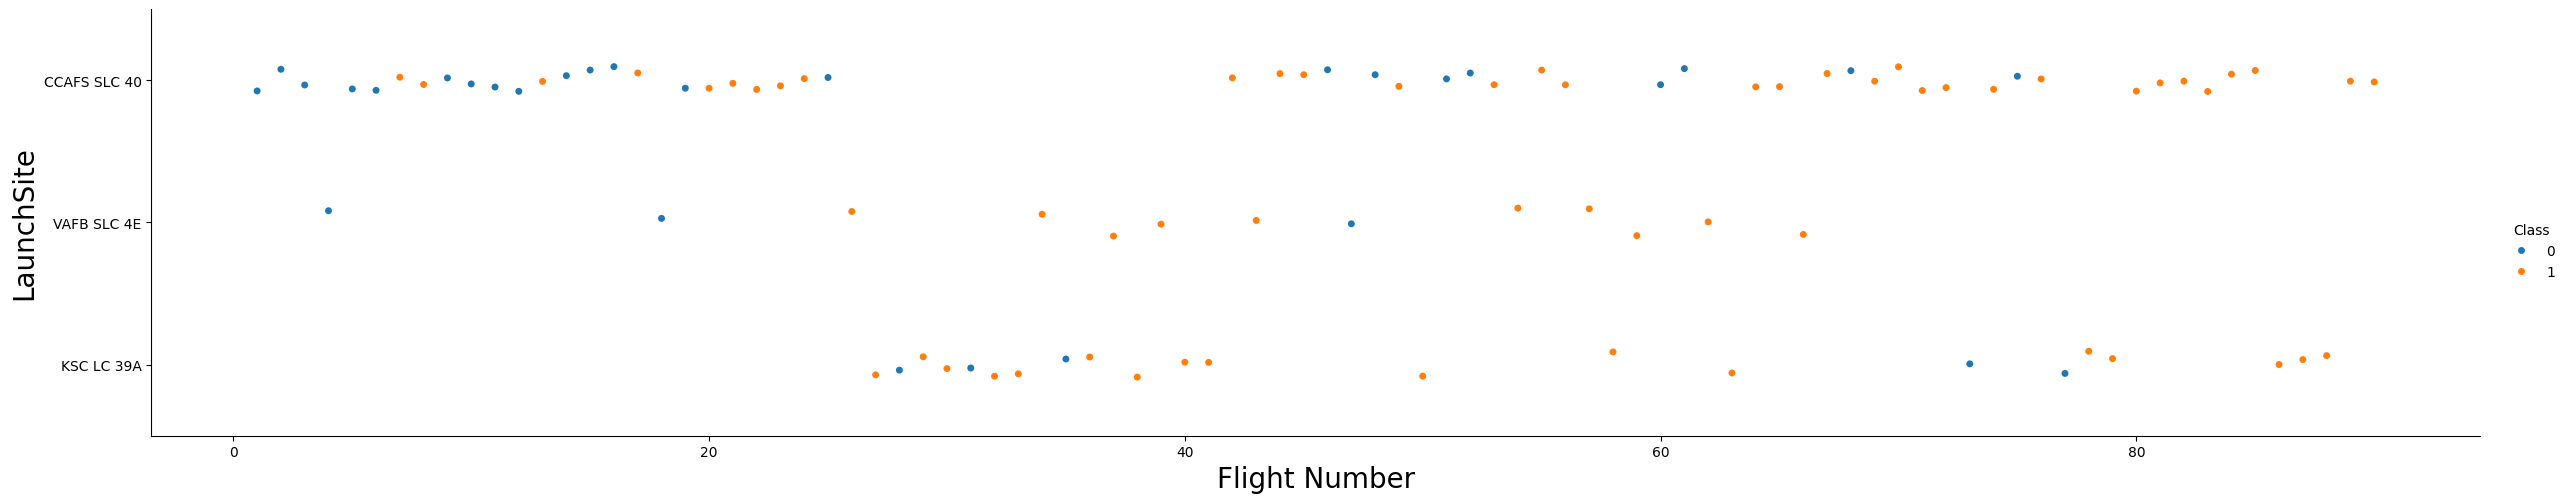

In [ ]:
# Plot a scatter point chart with x axis to be Flight Number and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

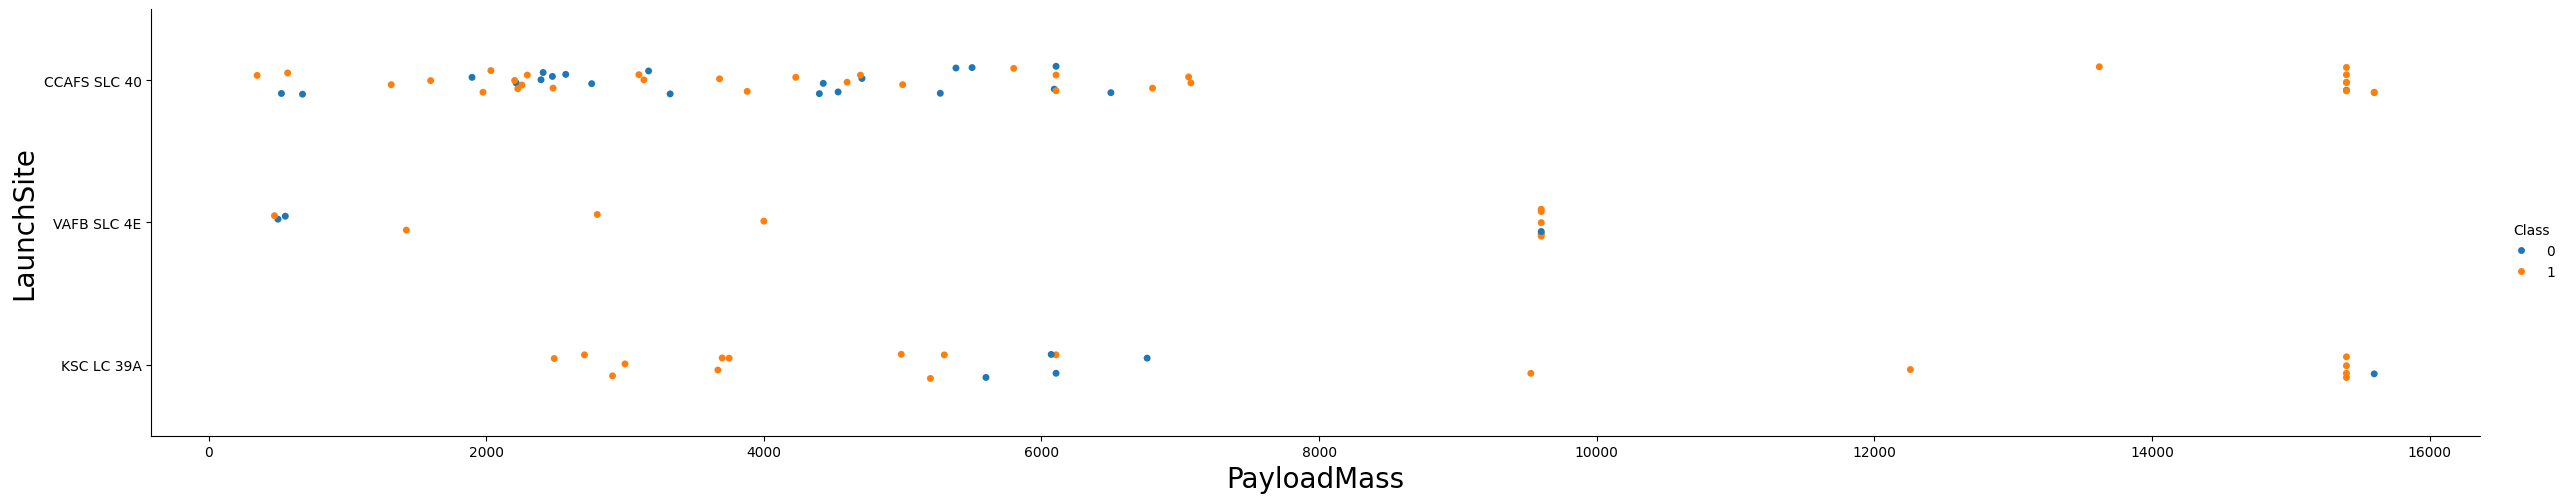

In [ ]:
# Plot a scatter point chart with x axis to be Pay Load Mass (kg) and y axis to be the launch site, and hue to be the class value
sns.catplot(y="LaunchSite",x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

C:\Users\dario\AppData\Local\Temp\ipykernel_7488\3865762212.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=success_rate_per_orbit.values,x=success_rate_per_orbit.index,palette="Blues_d")


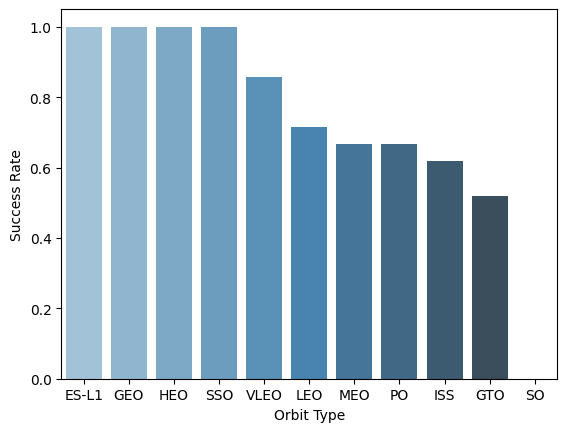

In [ ]:
# HINT use groupby method on Orbit column and get the mean of Class column
success_rate_per_orbit = df.groupby('Orbit')['Class'].mean()
success_rate_per_orbit = success_rate_per_orbit.sort_values(ascending=False)
sns.barplot(y=success_rate_per_orbit.values,x=success_rate_per_orbit.index,palette="Blues_d")
plt.ylabel('Success Rate')
plt.xlabel('Orbit Type')
plt.show()

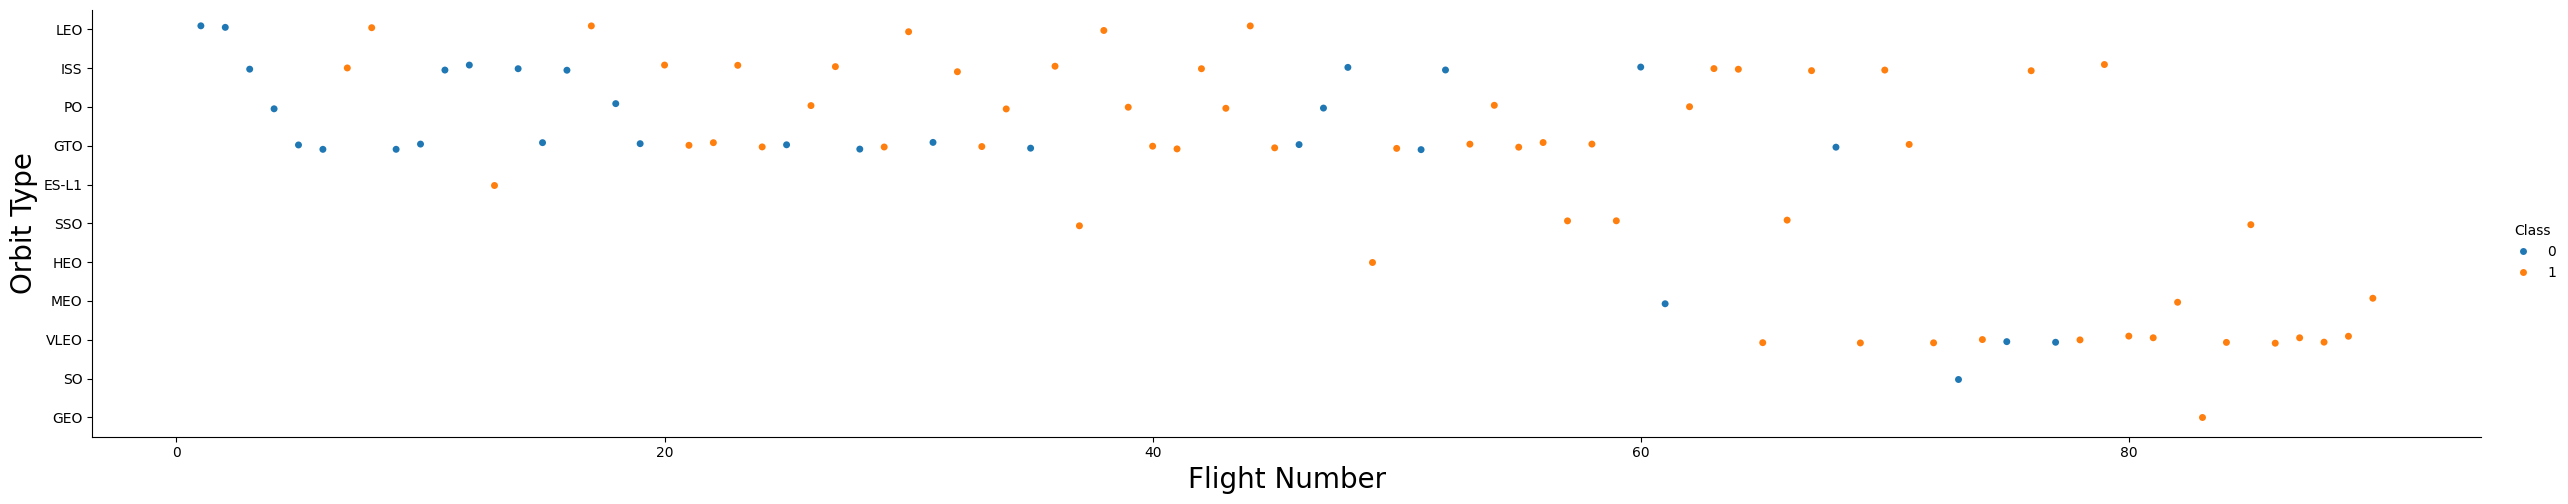

In [ ]:
# Plot a scatter point chart with x axis to be FlightNumber and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit",x="FlightNumber", hue="Class", data=df, aspect = 5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()


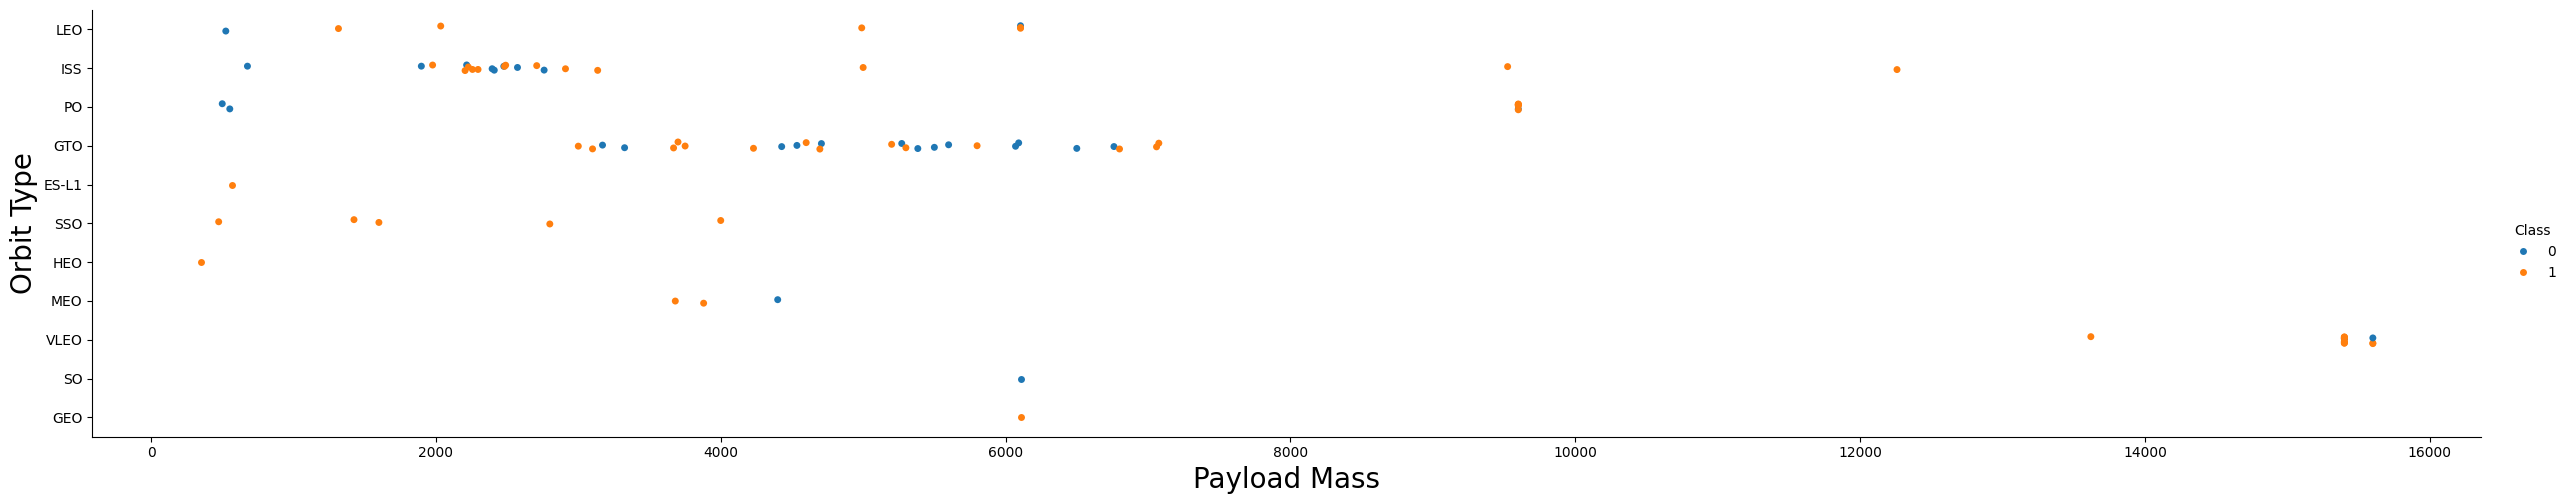

In [ ]:
# Plot a scatter point chart with x axis to be Payload Mass and y axis to be the Orbit, and hue to be the class value
sns.catplot(y="Orbit",x="PayloadMass", hue="Class", data=df, aspect = 5)
plt.xlabel("Payload Mass",fontsize=20)
plt.ylabel("Orbit Type",fontsize=20)
plt.show()

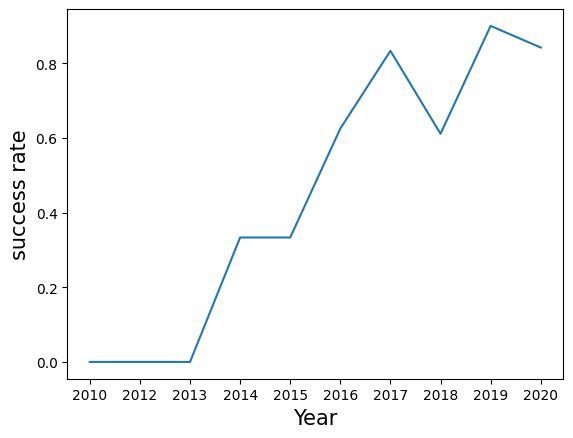

In [ ]:
# Plot a line chart with x axis to be the extracted year and y axis to be the success rate

sns.lineplot(data=success_rate_per_year_df, y=success_rate_per_year_df.Class,x=success_rate_per_year_df.Date)
plt.xlabel("Year",fontsize=15)
plt.ylabel("success rate",fontsize=15)
plt.show()

In [ ]:
# Environment setup (local Jupyter)
import sys

def check(pkg, import_name=None):
    name = import_name or pkg
    try:
        __import__(name)
    except ImportError:
        print(f"Package '{pkg}' not found. Please install it, e.g.: pip install -r requirements.txt")

for pkg, imp in [
    ("numpy", None),
    ("pandas", None),
    ("seaborn", None),
    ("matplotlib", None),
    ("scikit-learn", "sklearn"),
]:
    check(pkg, imp)

In [ ]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

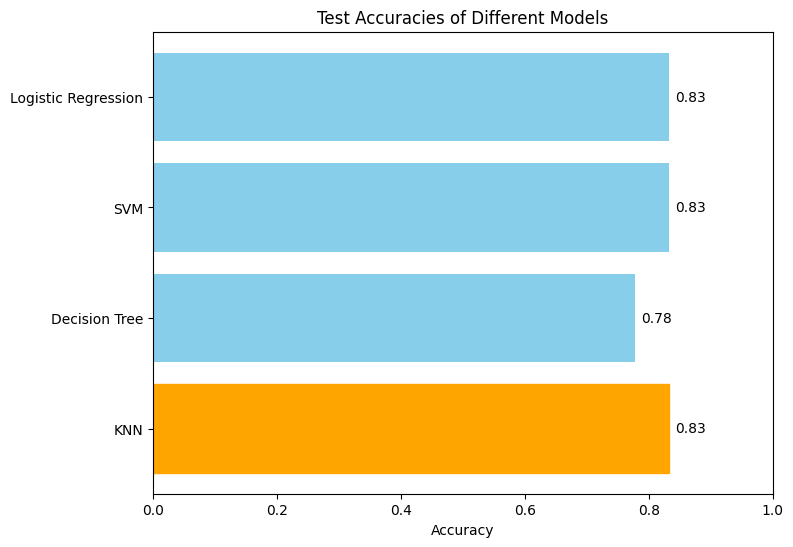

In [ ]:
# Visualisierung der Test-Genauigkeiten und Hervorhebung des besten Modells
import numpy as np
plt.figure(figsize=(8, 6))
models = list(test_accuracies.keys())
accuracies = list(test_accuracies.values())
bars = plt.barh(models, accuracies, color='skyblue')
best_idx = np.argmax(accuracies)
bars[best_idx].set_color('orange')
plt.xlabel('Accuracy')
plt.title('Test Accuracies of Different Models')
plt.xlim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center')
plt.show()

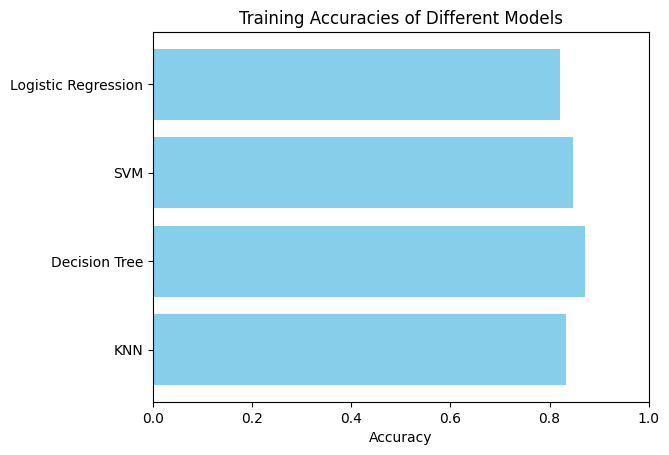

In [ ]:
#barplot of train accuracies
train_accuracies = {
    "KNN": knn_cv.best_score_,
    "Decision Tree": tree_cv.best_score_,
    "SVM": svm_cv.best_score_,
    "Logistic Regression": logreg_cv.best_score_
}
plt.barh(train_accuracies.keys(), train_accuracies.values(), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Training Accuracies of Different Models')
plt.xlim(0, 1)
plt.show()

In [ ]:
# Visualisierungen Zusammenstellen
viz_cells = []
viz_keys = ['plt.', 'seaborn', 'sns.', 'plot(', 'hist(', 'bar(', 'figure(']
for c in code_cells:
    txt = ''.join(c.get('source', []))
    if any(v in txt for v in viz_keys):
        viz_cells.append(c)
print('Visualisierungen:', len(viz_cells))

In [ ]:
# Summary of available model metrics (guarded)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

summary = []
models = [
    ('Logistic Regression', 'logreg_cv'),
    ('SVM', 'svm_cv'),
    ('Decision Tree', 'tree_cv'),
    ('KNN', 'knn_cv'),
]

for name, var in models:
    if var in globals():
        entry = {'model': name}
        try:
            cv = globals()[var]
            entry['cv_best_score'] = float(getattr(cv, 'best_score_', np.nan))
        except Exception:
            entry['cv_best_score'] = np.nan
        # Test accuracy if possible
        try:
            if 'X_test' in globals() and 'Y_test' in globals():
                yhat = globals()[var].predict(X_test)
                entry['test_accuracy'] = float((yhat == Y_test).mean())
            else:
                entry['test_accuracy'] = np.nan
        except Exception:
            entry['test_accuracy'] = np.nan
        summary.append(entry)

if summary:
    df_sum = pd.DataFrame(summary)
    display(df_sum)
    # Plot test accuracies if available
    if 'test_accuracy' in df_sum and df_sum['test_accuracy'].notna().any():
        plt.figure(figsize=(6,3))
        sns.barplot(data=df_sum, x='test_accuracy', y='model', orient='h')
        plt.title('Test accuracy by model (available)')
        plt.xlim(0,1)
        plt.show()
else:
    print('No model summaries available yet. Run training cells above first.')